In [1]:
import sys
sys.path.append('/projects/hp-ptycho/wjudge/ptychonn/ptychonn/')
from ptychnn_theta import *
from skimage.transform import resize
import matplotlib.pyplot as plt
from network_utils import *
#from tqdm import tqdm

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

ImportError: libmpi.so.12: cannot open shared object file: No such file or directory

In [43]:
data_num = 237

real_space = np.load(f"/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/{data_num}/recon_data.npy")
real_phi = np.angle(real_space)
real_phi = resize(real_phi, (949, 128, 128))
real_amp = np.abs(real_space)
real_amp = resize(real_amp, (949, 128, 128))
preds_amp = np.load(f"/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/{data_num}/pred_ampli.npy")
preds_phi = np.load(f"/projects/hp-ptycho/wjudge/ptychonn/scan_dataml/{data_num}/pred_phase.npy")

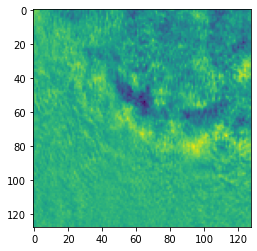

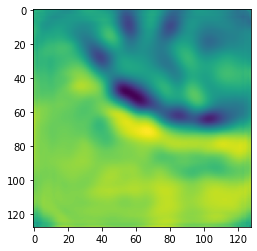

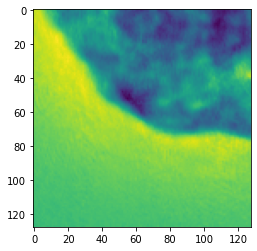

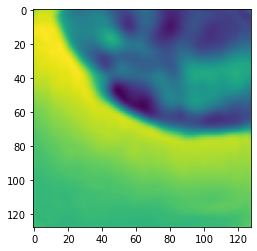

In [13]:
idx = 400

for d in [real_amp[idx], preds_amp[idx], real_phi[idx], preds_phi[idx]]:
    plt.imshow(d)
    plt.show()

In [44]:
base_path = '/projects/hp-ptycho/wjudge/'
data_path = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/eiger_4/S\
00000-00999/S00{data_num}/run_00{data_num}_000000000000.h5'

scan_path = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/scan_positions/scan_00{data_num}.dat'

scan = import_scan_paths(file=data_path, dat_file=scan_path, skiprows=2,
                         x_idx=2, y_idx=5, meter_convert=1e-6,
                          dist2det=2.97, ev=8800, detector_pixel_count=256, path_corr=[-1, -1])

pos = [scan[:, 1], scan[:, 0]]
pos = np.asarray(pos)

In [45]:
error = []
for data_num in range(data_num, data_num + 1):
    try:
        mat_loc = f'{base_path}ptychonn/bicer_data/28idc_2021-10-12/ptycho_reconstruct/catalyst/S00{data_num}/roi0_Ndp256/'
        mat_loc = determine_Niter(mat_loc)
        probe = import_probe(mat_file=mat_loc, useH5=True)
        pb_weights = resize(np.abs(probe[0, 0, 0, :, :]), (128, 128))
        #probe.shape
    except Exception as ex:
        error.append((data_num, ex))

In [46]:
pos_row = (pos[1]-np.min(pos[1]))
pos_col = (pos[0]-np.min(pos[0]))

print(pos_row.shape)

# integer position
pos_int_row = pos_row.astype(np.int32)
pos_int_col = pos_col.astype(np.int32)

pos_subpixel_row = pos_row - pos_int_row
pos_subpixel_col = pos_col - pos_int_col

(949,)


In [49]:
preds_amp = real_amp.copy()

H = 128
W = 128

hH = int(H/2)
hW = int(W/2)

composite_amp = np.zeros((np.max(pos_int_row)+H,np.max(pos_int_col)+W),float)

print(composite_amp.shape)
ctr = np.zeros_like(composite_amp)

data_reshaped = preds_amp.reshape(preds_amp.shape[0], H, W)
print(data_reshaped.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
#     weight_tmp = np.real(sub_shift.subpixel_shift(pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_amp[pos_int_row[i]:pos_int_row[i]+H,pos_int_col[i]:pos_int_col[i]+H] += data_reshaped[i] * pb_weights
    ctr[pos_int_row[i]:pos_int_row[i]+W,pos_int_col[i]:pos_int_col[i]+W] += pb_weights
    
composite_amp = composite_amp[hH:-hH,hW:-hW]
ctr = ctr[hH:-hH,hW:-hW]
   
print(composite_amp.shape)

(1447, 872)
(949, 128, 128)
(1319, 744)


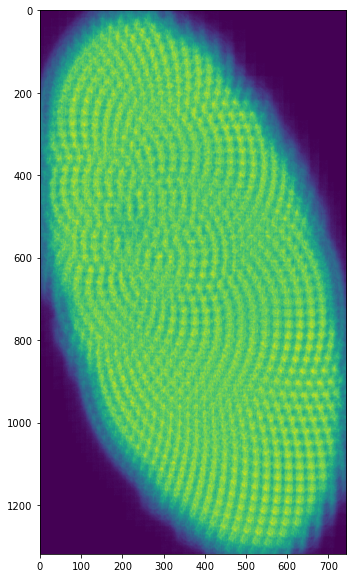

In [50]:
plt.figure(figsize=(10, 10))
plt.imshow(composite_amp)

In [8]:
composite_phase = np.zeros((np.max(pos_int_row)+H,np.max(pos_int_col)+W),float)
print(composite_phase.shape)

data_reshaped = preds_phi.reshape(preds_phi.shape[0],H,W)
print(data_reshaped.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_phase[pos_int_row[i]:pos_int_row[i]+H,pos_int_col[i]:pos_int_col[i]+W]  += data_reshaped[i] * pb_weights
    

composite_phase = composite_phase[hH:-hH,hW:-hW]

print(composite_phase.shape)

(1447, 872)
(949, 128, 128)
(1319, 744)


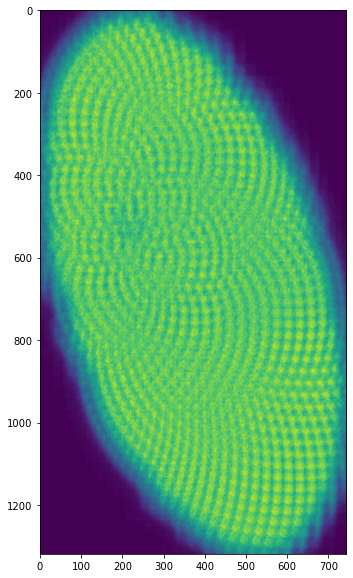

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(composite_amp, vmin=0,)